The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.16.0


# Anchor Boxes
:label:`sec_anchor`

Object detection algorithms usually sample a large number of regions in the input image, determine whether these regions contain objects of interest, and adjust the edges of the regions so as to predict the ground-truth bounding box of the target more accurately. Different models may use different region sampling methods. Here, we introduce one such method: it generates multiple bounding boxes with different sizes and aspect ratios while centering on each pixel. These bounding boxes are called anchor boxes. We will practice object detection based on anchor boxes in the following sections.


First, import the packages or modules required for this section. Here, we have modified the printing accuracy of PyTorch. Because printing tensors actually calls the print function of PyTorch, the floating-point numbers in tensors printed in this section are more concise.


In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torchvision

torch.set_printoptions(2)

## Generating Multiple Anchor Boxes

Assume that the input image has a height of $h$ and width of $w$. We generate anchor boxes with different shapes centered on each pixel of the image. Assume the size is $s\in (0, 1]$, the aspect ratio is $r > 0$, and the width and height of the anchor box are $ws\sqrt{r}$ and $hs/\sqrt{r}$, respectively.  When the center position is given, an anchor box with known width and height is determined.

Below we set a set of sizes $s_1,\ldots, s_n$ and a set of aspect ratios $r_1,\ldots, r_m$. If we use a combination of all sizes and aspect ratios with each pixel as the center, the input image will have a total of $whnm$ anchor boxes. Although these anchor boxes may cover all ground-truth bounding boxes, the computational complexity is often excessive. Therefore, we are usually only interested in a combination containing $s_1$ or $r_1$ sizes and aspect ratios, that is:

$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$

That is, the number of anchor boxes centered on the same pixel is $n+m-1$. For the entire input image, we will generate a total of $wh(n+m-1)$ anchor boxes.

The above method of generating anchor boxes has been implemented in the `multibox_prior` function. We specify the input, a set of sizes, and a set of aspect ratios, and this function will return all the anchor boxes entered.


In [2]:
#@save
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to center of a pixel
    # Since pixel (height=1, width=1), we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate boxes_per_pixel number of heights and widths which are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor, sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                * in_height / in_width / 2
    h = torch.cat((size_tensor, sizes[0] / torch.sqrt(ratio_tensor[1:]))) / 2
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1)

    # Each center point will have boxes_per_pixel number of anchor boxes, so
    # generate grid of all anchor box centers with boxes_per_pixel repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

We can see that the shape of the returned anchor box variable `y` is
(batch size, number of anchor boxes, 4).


In [3]:
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[0:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))  # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

After changing the shape of the anchor box variable `y` to (image height, image width, number of anchor boxes centered on the same pixel, 4), we can obtain all the anchor boxes centered on a specified pixel position. In the following example, we access the first anchor box centered on (250, 250). It has four elements: the $x, y$ axis coordinates in the upper-left corner and the $x, y$ axis coordinates in the lower-right corner of the anchor box. The coordinate values of the $x$ and $y$ axis are divided by the width and height of the image, respectively, so the value range is between 0 and 1.


In [4]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In order to describe all anchor boxes centered on one pixel in the image, we first define the `show_bboxes` function to draw multiple bounding boxes on the image.


In [5]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(d2l.numpy(bbox), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

As we just saw, the coordinate values of the $x$ and $y$ axis in the variable `boxes` have been divided by the width and height of the image, respectively. When drawing images, we need to restore the original coordinate values of the anchor boxes and therefore define the variable `bbox_scale`. Now, we can draw all the anchor boxes centered on (250, 250) in the image. As you can see, the blue anchor box with a size of 0.75 and an aspect ratio of 1 covers the dog in the image well.


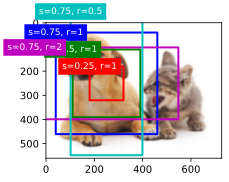

In [6]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

## Intersection over Union

We just mentioned that the anchor box covers the dog in the image well. If the ground-truth bounding box of the target is known, how can "well" here be quantified? An intuitive method is to measure the similarity between anchor boxes and the ground-truth bounding box. We know that the Jaccard index can measure the similarity between two sets. Given sets $\mathcal{A}$ and $\mathcal{B}$, their Jaccard index is the size of their intersection divided by the size of their union:

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$


In fact, we can consider the pixel area of a bounding box as a collection of pixels. In this way, we can measure the similarity of the two bounding boxes by the Jaccard index of their pixel sets. When we measure the similarity of two bounding boxes, we usually refer the Jaccard index as intersection over union (IoU), which is the ratio of the intersecting area to the union area of the two bounding boxes, as shown in :numref:`fig_iou`. The value range of IoU is between 0 and 1: 0 means that there are no overlapping pixels between the two bounding boxes, while 1 indicates that the two bounding boxes are equal.

![IoU is the ratio of the intersecting area to the union area of two bounding boxes.  ](http://d2l.ai/_images/iou.svg)
:label:`fig_iou`


For the remainder of this section, we will use IoU to measure the similarity between anchor boxes and ground-truth bounding boxes, and between different anchor boxes.


In [7]:
#@save
def box_iou(boxes1, boxes2):
    """Compute IOU between two sets of boxes of shape (N,4) and (M,4)."""
    # Compute box areas
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]
    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]
    unioun = area1[:, None] + area2 - inter
    return inter / unioun

## Labeling Training Set Anchor Boxes


In the training set, we consider each anchor box as a training example. In order to train the object detection model, we need to mark two types of labels for each anchor box: first, the category of the target contained in the anchor box (category) and, second, the offset of the ground-truth bounding box relative to the anchor box (offset). In object detection, we first generate multiple anchor boxes, predict the categories and offsets for each anchor box, adjust the anchor box position according to the predicted offset to obtain the bounding boxes to be used for prediction, and finally filter out the prediction bounding boxes that need to be output.


We know that, in the object detection training set, each image is labelled with the location of the ground-truth bounding box and the category of the target contained. After the anchor boxes are generated, we primarily label anchor boxes based on the location and category information of the ground-truth bounding boxes similar to the anchor boxes. So how do we assign ground-truth bounding boxes to anchor boxes similar to them?


Assume that the anchor boxes in the image are $A_1, A_2, \ldots, A_{n_a}$ and the ground-truth bounding boxes are $B_1, B_2, \ldots, B_{n_b}$ and $n_a \geq n_b$. Define matrix $\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$, where element $x_{ij}$ in the $i^\mathrm{th}$ row and $j^\mathrm{th}$ column is the IoU of the anchor box $A_i$ to the ground-truth bounding box $B_j$.
First, we find the largest element in the matrix $\mathbf{X}$ and record the row index and column index of the element as $i_1,j_1$. We assign the ground-truth bounding box $B_{j_1}$ to the anchor box $A_{i_1}$. Obviously, anchor box $A_{i_1}$ and ground-truth bounding box $B_{j_1}$ have the highest similarity among all the "anchor box--ground-truth bounding box" pairings. Next, discard all elements in the $i_1$th row and the $j_1$th column in the matrix $\mathbf{X}$. Find the largest remaining element in the matrix $\mathbf{X}$ and record the row index and column index of the element as $i_2,j_2$. We assign ground-truth bounding box $B_{j_2}$ to anchor box $A_{i_2}$ and then discard all elements in the $i_2$th row and the $j_2$th column in the matrix $\mathbf{X}$. At this point, elements in two rows and two columns in the matrix $\mathbf{X}$ have been discarded.


We proceed until all elements in the $n_b$ column in the matrix $\mathbf{X}$ are discarded. At this time, we have assigned a ground-truth bounding box to each of the $n_b$ anchor boxes.
Next, we only traverse the remaining $n_a - n_b$ anchor boxes. Given anchor box $A_i$, find the bounding box $B_j$ with the largest IoU with $A_i$ according to the $i^\mathrm{th}$ row of the matrix $\mathbf{X}$, and only assign ground-truth bounding box $B_j$ to anchor box $A_i$ when the IoU is greater than the predetermined threshold.


As shown in :numref:`fig_anchor_label` (left), assuming that the maximum value in the matrix $\mathbf{X}$ is $x_{23}$, we will assign ground-truth bounding box $B_3$ to anchor box $A_2$. Then, we discard all the elements in row 2 and column 3 of the matrix, find the largest element $x_{71}$ of the remaining shaded area, and assign ground-truth bounding box $B_1$ to anchor box $A_7$. Then, as shown in :numref:`fig_anchor_label`  (middle), discard all the elements in row 7 and column 1 of the matrix, find the largest element $x_{54}$ of the remaining shaded area, and assign ground-truth bounding box $B_4$ to anchor box $A_5$.  Finally, as shown in :numref:`fig_anchor_label` (right), discard all the elements in row 5 and column 4 of the matrix, find the largest element $x_{92}$ of the remaining shaded area, and assign ground-truth bounding box $B_2$ to anchor box $A_9$.  After that, we only need to traverse the remaining anchor boxes of $A_1, A_3, A_4, A_6, A_8$ and determine whether to assign ground-truth bounding boxes to the remaining anchor boxes according to the threshold.

![Assign ground-truth bounding boxes to anchor boxes. ](../img/anchor-label.svg)
:label:`fig_anchor_label`


In [8]:
#@save
def match_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign ground-truth bounding boxes to anchor boxes similar to them."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element `x_ij` in the `i^th` row and `j^th` column is the IoU
    # of the anchor box `anc_i` to the ground-truth bounding box `box_j`
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold assigned ground truth bbox for each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground truth bounding box according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    # Find the largest iou for each bbox
    anc_i = torch.argmax(jaccard, dim=0)
    box_j = torch.arange(num_gt_boxes, device=device)
    anchors_bbox_map[anc_i] = box_j
    return anchors_bbox_map

Now we can label the categories and offsets of the anchor boxes. If an anchor box $A$ is assigned ground-truth bounding box $B$, the category of the anchor box $A$ is set to the category of $B$. And the offset of the anchor box $A$ is set according to the relative position of the central coordinates of $B$ and $A$ and the relative sizes of the two boxes. Because the positions and sizes of various boxes in the dataset may vary, these relative positions and relative sizes usually require some special transformations to make the offset distribution more uniform and easier to fit. Assume the center coordinates of anchor box $A$ and its assigned ground-truth bounding box $B$ are $(x_a, y_a), (x_b, y_b)$, the widths of $A$ and $B$ are $w_a, w_b$, and their heights are $h_a, h_b$, respectively. In this case, a common technique is to label the offset of $A$ as

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

The default values of the constant are $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1, and \sigma_w=\sigma_h=0.2$.
This transformation is implemented below in the `offset_boxes` function.
If an anchor box is not assigned a ground-truth bounding box, we only need to set the category of the anchor box to background. Anchor boxes whose category is background are often referred to as negative anchor boxes, and the rest are referred to as positive anchor boxes.


In [9]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [10]:
#@save
def multibox_target(anchors, labels):
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = match_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # Initialize class_labels and assigned bbox coordinates with zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Assign class labels to the anchor boxes using matched gt bbox labels
        # If no gt bbox is assigned to an anchor box, then let the
        # class_labels and assigned_bb remain zero, i.e the background class
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # offset transformations
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

Below we demonstrate a detailed example. We define ground-truth bounding boxes for the cat and dog in the read image, where the first element is category (0 for dog, 1 for cat) and the remaining four elements are the $x, y$ axis coordinates at top-left corner and $x, y$ axis coordinates at lower-right corner (the value range is between 0 and 1). Here, we construct five anchor boxes to be labeled by the coordinates of the upper-left corner and the lower-right corner, which are recorded as $A_0, \ldots, A_4$, respectively (the index in the program starts from 0). First, draw the positions of these anchor boxes and the ground-truth bounding boxes in the image.


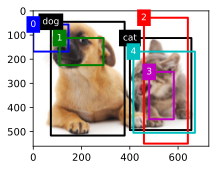

In [11]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

We can label categories and offsets for anchor boxes by using the `multibox_target` function. This function sets the background category to 0 and increments the integer index of the target category from zero by 1 (1 for dog and 2 for cat).


We add example dimensions to the anchor boxes and ground-truth bounding boxes and construct random predicted results with a shape of (batch size, number of categories including background, number of anchor boxes) by using the `unsqueeze` function.


In [12]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

There are three items in the returned result, all of which are in the tensor format. The third item is represented by the category labeled for the anchor box.


In [13]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

We analyze these labelled categories based on positions of anchor boxes and ground-truth bounding boxes in the image. First, in all "anchor box--ground-truth bounding box" pairs, the IoU of anchor box $A_4$ to the ground-truth bounding box of the cat is the largest, so the category of anchor box $A_4$ is labeled as cat. Without considering anchor box $A_4$ or the ground-truth bounding box of the cat, in the remaining "anchor box--ground-truth bounding box" pairs, the pair with the largest IoU is anchor box $A_1$ and the ground-truth bounding box of the dog, so the category of anchor box $A_1$ is labeled as dog. Next, traverse the remaining three unlabeled anchor boxes. The category of the ground-truth bounding box with the largest IoU with anchor box $A_0$ is dog, but the IoU is smaller than the threshold (the default is 0.5), so the category is labeled as background; the category of the ground-truth bounding box with the largest IoU with anchor box $A_2$ is cat and the IoU is greater than the threshold, so the category is labeled as cat; the category of the ground-truth bounding box with the largest IoU with anchor box $A_3$ is cat, but the IoU is smaller than the threshold, so the category is labeled as background.


The second item of the return value is a mask variable, with the shape of (batch size, four times the number of anchor boxes). The elements in the mask variable correspond one-to-one with the four offset values of each anchor box.
Because we do not care about background detection, offsets of the negative class should not affect the target function. By multiplying by element, the 0 in the mask variable can filter out negative class offsets before calculating target function.


In [14]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

The first item returned is the four offset values labeled for each anchor box, with the offsets of negative class anchor boxes labeled as 0.


In [15]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

## Bounding Boxes for Prediction

During model prediction phase, we first generate multiple anchor boxes for the image and then predict categories and offsets for these anchor boxes one by one. Then, we obtain prediction bounding boxes based on anchor boxes and their predicted offsets.

Below we implement function `offset_inverse` which takes in anchors and
offset predictions as inputs and applies inverse offset transformations to
return the predicted bounding box coordinates.


In [16]:
#@save
def offset_inverse(anchors, offset_preds):
    c_anc = d2l.box_corner_to_center(anchors)
    c_pred_bb_xy = (offset_preds[:, :2] * c_anc[:, 2:] / 10) + c_anc[:, :2]
    c_pred_bb_wh = torch.exp(offset_preds[:, 2:] / 5) * c_anc[:, 2:]
    c_pred_bb = torch.cat((c_pred_bb_xy, c_pred_bb_wh), axis=1)
    predicted_bb = d2l.box_center_to_corner(c_pred_bb)
    return predicted_bb

When there are many anchor boxes, many similar prediction bounding boxes may be output for the same target. To simplify the results, we can remove similar prediction bounding boxes. A commonly used method is called non-maximum suppression (NMS).

Let us take a look at how NMS works. For a prediction bounding box $B$, the model calculates the predicted probability for each category. Assume the largest predicted probability is $p$, the category corresponding to this probability is the predicted category of $B$. We also refer to $p$ as the confidence level of prediction bounding box $B$. On the same image, we sort the prediction bounding boxes with predicted categories other than background by confidence level from high to low, and obtain the list $L$. Select the prediction bounding box $B_1$ with highest confidence level from $L$ as a baseline and remove all non-benchmark prediction bounding boxes with an IoU with $B_1$ greater than a certain threshold from $L$. The threshold here is a preset hyperparameter. At this point, $L$ retains the prediction bounding box with the highest confidence level and removes other prediction bounding boxes similar to it.
Next, select the prediction bounding box $B_2$ with the second highest confidence level from $L$ as a baseline, and remove all non-benchmark prediction bounding boxes with an IoU with $B_2$ greater than a certain threshold from $L$. Repeat this process until all prediction bounding boxes in $L$ have been used as a baseline. At this time, the IoU of any pair of prediction bounding boxes in $L$ is less than the threshold. Finally, output all prediction bounding boxes in the list $L$.


In [17]:
#@save
def nms(boxes, scores, iou_threshold):
    # sorting scores by the descending order and return their indices
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # boxes indices that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.00999999978):
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, 0.5)
        # Find all non_keep indices and set the class_id to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # threshold to be a positive prediction
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

Next, we will look at a detailed example. First, construct four anchor boxes. For the sake of simplicity, we assume that predicted offsets are all 0. This means that the prediction bounding boxes are anchor boxes. Finally, we construct a predicted probability for each category.


In [18]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                    [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * d2l.size(anchors))
cls_probs = torch.tensor([[0] * 4,  # Predicted probability for background
                      [0.9, 0.8, 0.7, 0.1],  # Predicted probability for dog
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted probability for cat

Print prediction bounding boxes and their confidence levels on the image.


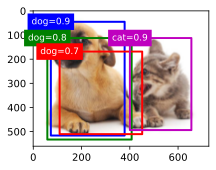

In [19]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

We use the `multibox_detection` function to perform NMS and set the threshold to 0.5. This adds an example dimension to the tensor input. We can see that the shape of the returned result is (batch size, number of anchor boxes, 6). The 6 elements of each row represent the output information for the same prediction bounding box. The first element is the predicted category index, which starts from 0 (0 is dog, 1 is cat). The value -1 indicates background or removal in NMS. The second element is the confidence level of prediction bounding box. The remaining four elements are the $x, y$ axis coordinates of the upper-left corner and the $x, y$ axis coordinates of the lower-right corner of the prediction bounding box (the value range is between 0 and 1).


In [20]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

We remove the prediction bounding boxes of category -1 and visualize the results retained by NMS.


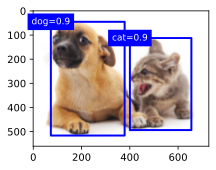

In [21]:
fig = d2l.plt.imshow(img)
for i in d2l.numpy(output[0]):
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In practice, we can remove prediction bounding boxes with lower confidence levels before performing NMS, thereby reducing the amount of computation for NMS. We can also filter the output of NMS, for example, by only retaining results with higher confidence levels as the final output.


## Summary

* We generate multiple anchor boxes with different sizes and aspect ratios, centered on each pixel.
* IoU, also called Jaccard index, measures the similarity of two bounding boxes. It is the ratio of the intersecting area to the union area of two bounding boxes.
* In the training set, we mark two types of labels for each anchor box: one is the category of the target contained in the anchor box and the other is the offset of the ground-truth bounding box relative to the anchor box.
* When predicting, we can use non-maximum suppression (NMS) to remove similar prediction bounding boxes, thereby simplifying the results.

## Exercises

1. Change the `sizes` and `ratios` values in the `multibox_prior` function and observe the changes to the generated anchor boxes.
1. Construct two bounding boxes with an IoU of 0.5, and observe their coincidence.
1. Verify the output of offset `labels[0]` by marking the anchor box offsets as defined in this section (the constant is the default value).
1. Modify the variable `anchors` in the "Labeling Training Set Anchor Boxes" and "Output Bounding Boxes for Prediction" sections. How do the results change?


[Discussions](https://discuss.d2l.ai/t/1603)
